# Stage 09 — Homework Starter Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/options_data_20250823_163952.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (496, 18)

Columns: ['symbol', 'underlying_symbol', 'strike', 'expiration_date', 'contract_type', 'implied_volatility', 'open_interest', 'volume', 'bid', 'ask', 'last_price', 'market_price', 'underlying_price', 'risk_free_rate', 'fetch_timestamp', 'time_to_expiry', 'data_source', 'simulated_trade_date']

First few rows:


,symbol,underlying_symbol,strike,expiration_date,contract_type,implied_volatility,open_interest,volume,bid,ask,last_price,market_price,underlying_price,risk_free_rate,fetch_timestamp,time_to_expiry,data_source,simulated_trade_date
0,SPY20250825C00530000,SPY,530.0,2025-08-25,call,0.841798,11.0,11.0,113.98,116.78,106.25,115.380,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
1,SPY20250825C00550000,SPY,550.0,2025-08-25,call,0.703128,2.0,2.0,93.98,96.79,96.12,95.385,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
2,SPY20250825C00570000,SPY,570.0,2025-08-25,call,0.565434,2.0,240.0,73.99,76.79,75.03,75.390,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
3,SPY20250825C00580000,SPY,580.0,2025-08-25,call,0.813478,3.0,233.0,63.99,66.80,66.14,65.395,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
4,SPY20250825C00590000,SPY,590.0,2025-08-25,call,0.710940,1.0,284.0,53.99,56.80,55.93,55.395,645.309998,0.04088,2025-08-23 16:39:40.713785,0.00274,yahoo_finance,2025-08-22 16:39:41.671421


In [3]:
# Data overview
print("Contract types:", df['contract_type'].value_counts())
print("\nBasic statistics:")
print(df[['strike', 'underlying_price', 'implied_volatility', 'volume', 'open_interest']].describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Contract types: contract_type
call    248
put     248
Name: count, dtype: int64

Basic statistics:
           strike  underlying_price  implied_volatility       volume  \
count  496.000000        496.000000          496.000000   496.000000   
mean   494.389113        645.309998            0.578538   458.782258   
std    134.100278          0.000000            0.450475  1092.227076   
min    150.000000        645.309998            0.000010     0.000000   
25%    418.750000        645.309998            0.210762     2.000000   
50%    520.000000        645.309998            0.503850    20.500000   
75%    611.250000        645.309998            0.812502   319.750000   
max    656.000000        645.309998            2.281254  9260.000000   

       open_interest  
count     496.000000  
mean     1149.209677  
std      4259.863074  
min         0.000000  
25%        21.000000  
50%       198.000000  
75%       859.000000  
max     76712.000000  

Missing values:
symbol                  0
un

## Engineered Feature

### Feature 1: Moneyness
# Measures how far in-the-money (ITM) or out-of-the-money (OTM) an option is

### Rationale for Feature 1: Moneyness

**Why this feature matters:**
- **Options Pricing**: Moneyness is fundamental to option value - ITM options have intrinsic value, OTM options only have time value
- **Trading Strategy**: Traders often focus on specific moneyness ranges (e.g., ATM options for volatility plays)
- **Risk Assessment**: Moneyness indicates probability of exercise and potential profit/loss

**Business Impact:**
- Helps predict which options are more likely to be exercised
- Useful for portfolio risk management and hedging strategies
- Can identify arbitrage opportunities when pricing deviates from theoretical values

In [4]:
def calculate_moneyness(row):
    """
    Calculate moneyness for both calls and puts
    - For calls: (Underlying Price - Strike Price) / Strike Price
    - For puts: (Strike Price - Underlying Price) / Strike Price
    - Positive values = In-the-money
    - Negative values = Out-of-the-money
    """
    if row['contract_type'] == 'call':
        return (row['underlying_price'] - row['strike']) / row['strike']
    else:  # put
        return (row['strike'] - row['underlying_price']) / row['strike']

df['moneyness'] = df.apply(calculate_moneyness, axis=1)

# Display distribution
print("Moneyness statistics:")
print(df['moneyness'].describe())
print(f"\nIn-the-money options: {(df['moneyness'] > 0).sum()} ({(df['moneyness'] > 0).mean():.1%})")
print(f"Out-of-the-money options: {(df['moneyness'] <= 0).sum()} ({(df['moneyness'] <= 0).mean():.1%})")

Moneyness statistics:
count    496.000000
mean      -0.064163
std        0.801603
min       -3.302067
25%       -0.330536
50%       -0.021113
75%        0.096083
max        3.302067
Name: moneyness, dtype: float64

In-the-money options: 227 (45.8%)
Out-of-the-money options: 269 (54.2%)


# Feature 2: Bid-Ask Spread Ratio
Measures the relative cost of trading (liquidity indicator)

### Rationale for Feature 2: Bid-Ask Spread Ratio

**Why this feature matters:**
- **Transaction Costs**: Higher spread ratios indicate higher trading costs
- **Liquidity Measure**: Tight spreads suggest high liquidity and efficient price discovery
- **Market Quality**: Wide spreads may indicate information asymmetry or low trading interest

**Trading Implications:**
- Options with high spread ratios are more expensive to trade
- Liquidity affects the ability to enter/exit positions quickly
- Market makers price in higher spreads for riskier or less traded options

**Model Benefits:**
- Helps predict trading difficulty and execution costs
- Useful for algorithmic trading strategies
- Can identify potentially mispriced options in illiquid markets

In [8]:
df['bid_ask_spread'] = df['ask'] - df['bid']
df['bid_ask_spread_ratio'] = df['bid_ask_spread'] / df['market_price']

# Division by zero or infinite values
df['bid_ask_spread_ratio'] = df['bid_ask_spread_ratio'].replace([np.inf, -np.inf], np.nan)

print("Bid-Ask Spread Ratio statistics:")
print(df['bid_ask_spread_ratio'].describe())

# Categorize liquidity levels
df['liquidity_category'] = pd.cut(df['bid_ask_spread_ratio'], 
                                 bins=[0, 0.02, 0.05, 0.10, 1.0], 
                                 labels=['Very Liquid', 'Liquid', 'Moderate', 'Illiquid'],
                                 include_lowest=True)

print("\nLiquidity distribution:")
print(df['liquidity_category'].value_counts())

Bid-Ask Spread Ratio statistics:
count    496.000000
mean       0.330013
std        0.396059
min        0.000000
25%        0.012132
50%        0.095238
75%        0.666667
max        1.000000
Name: bid_ask_spread_ratio, dtype: float64

Liquidity distribution:
liquidity_category
Illiquid       244
Very Liquid    172
Liquid          44
Moderate        36
Name: count, dtype: int64


# Feature 3: Volume-to-Open Interest Ratio
Measures current trading activity relative to total outstanding contracts

### Rationale for Feature 3: Volume-to-Open Interest Ratio

**Why this feature matters:**
- **Trading Interest**: High ratios indicate current market interest relative to existing positions
- **Position Changes**: Reveals whether traders are opening new positions or closing existing ones
- **Market Sentiment**: Sudden spikes may indicate news, events, or strategy shifts

**Trading Insights:**
- Ratio > 1: More contracts traded today than total outstanding (high turnover)
- Ratio < 0.1: Low current interest relative to existing positions
- Very high ratios may indicate unusual options activity (UOA)

**Predictive Value:**
- Can identify options with unusual trading patterns
- Helps predict future price movements and volatility
- Useful for detecting institutional activity or informed trading

In [6]:
# Cases where open_interest is 0 to avoid division by zero
df['volume_oi_ratio'] = np.where(df['open_interest'] > 0, 
                                df['volume'] / df['open_interest'], 
                                np.nan)

print("Volume-to-Open Interest Ratio statistics:")
print(df['volume_oi_ratio'].describe())

# Categorizing trading activity levels
# Reasonable percentiles for categories
percentiles = df['volume_oi_ratio'].quantile([0.25, 0.5, 0.75]).values

df['trading_activity'] = pd.cut(df['volume_oi_ratio'], 
                               bins=[0, percentiles[0], percentiles[1], percentiles[2], np.inf], 
                               labels=['Low Activity', 'Moderate Activity', 'High Activity', 'Very High Activity'],
                               include_lowest=True)

print("\nTrading activity distribution:")
print(df['trading_activity'].value_counts())

# Examples of high activity options
print("\nTop 5 most active options (highest volume/OI ratio):")
high_activity = df.nlargest(5, 'volume_oi_ratio')[['symbol', 'strike', 'contract_type', 'volume', 'open_interest', 'volume_oi_ratio']]
print(high_activity)

Volume-to-Open Interest Ratio statistics:
count    480.000000
mean       3.183682
std       22.462172
min        0.000000
25%        0.033065
50%        0.324882
75%        1.084848
max      357.142857
Name: volume_oi_ratio, dtype: float64

Trading activity distribution:
trading_activity
Low Activity          120
Moderate Activity     120
High Activity         120
Very High Activity    120
Name: count, dtype: int64

Top 5 most active options (highest volume/OI ratio):
                   symbol  strike contract_type  volume  open_interest  \
167  SPY20250827P00545000   545.0           put  2500.0            7.0   
4    SPY20250825C00590000   590.0          call   284.0            1.0   
2    SPY20250825C00570000   570.0          call   240.0            2.0   
168  SPY20250827P00550000   550.0           put  1842.0           18.0   
3    SPY20250825C00580000   580.0          call   233.0            3.0   

     volume_oi_ratio  
167       357.142857  
4         284.000000  
2         120

## Visualization and Analysis

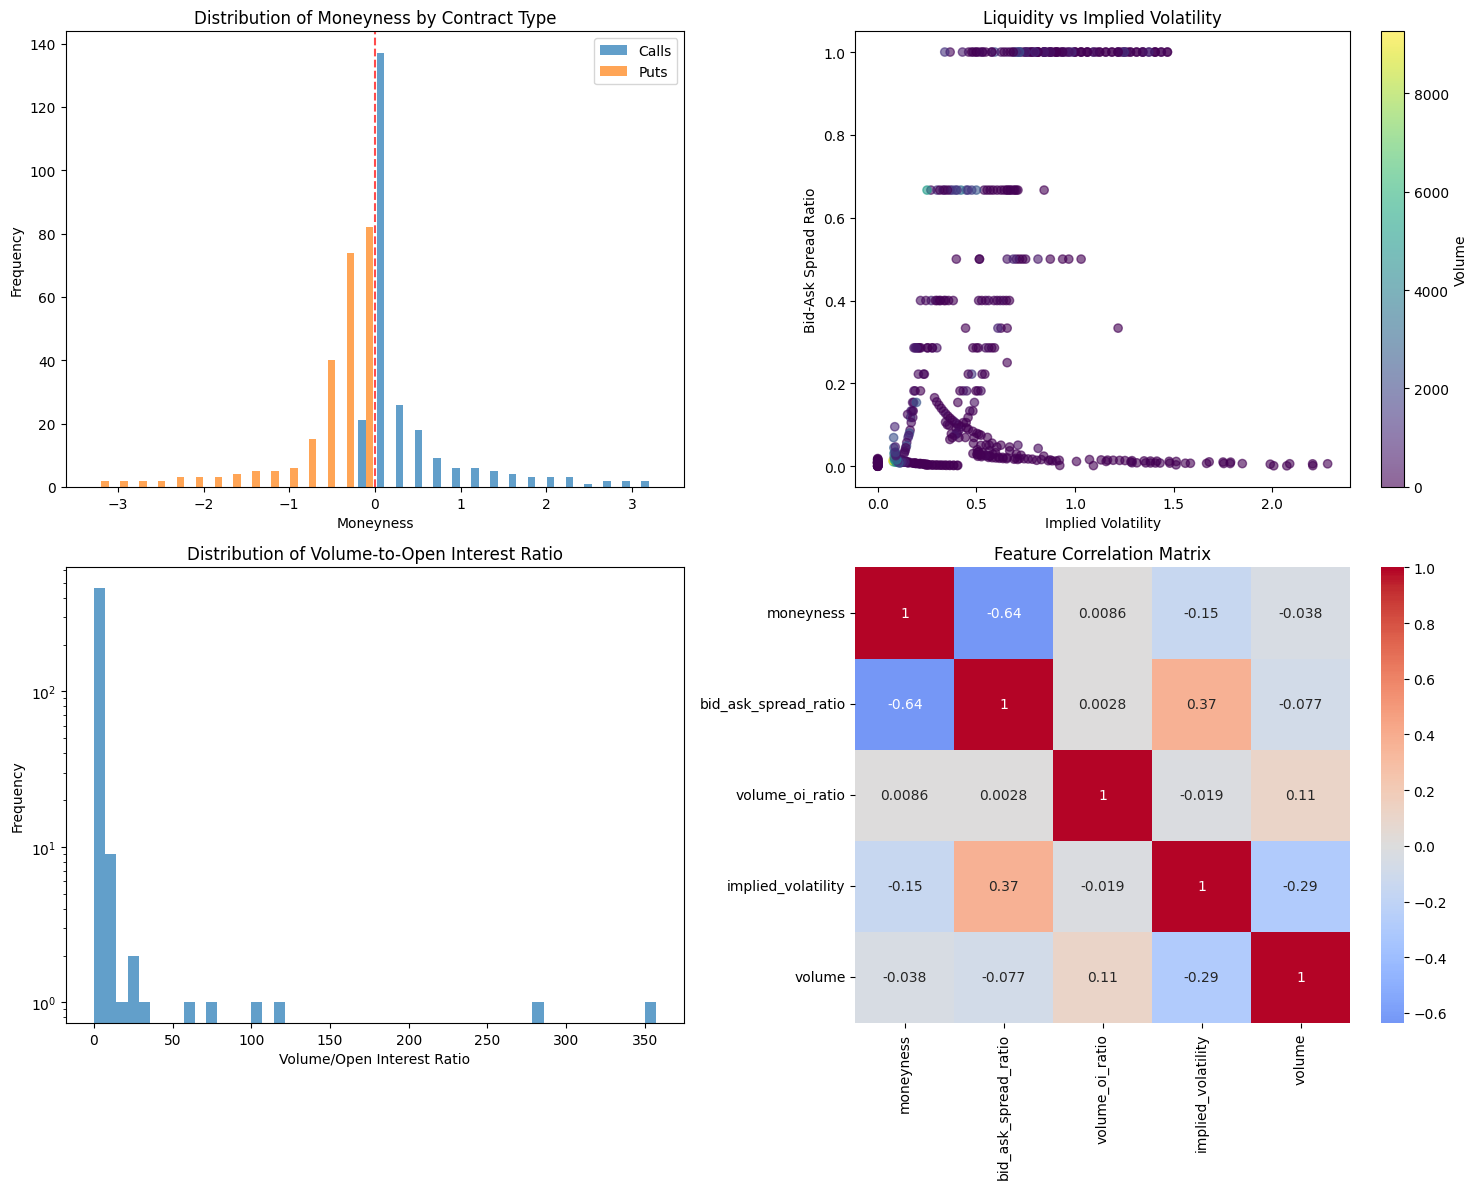

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Moneyness distribution by contract type
axes[0,0].hist([df[df['contract_type']=='call']['moneyness'], 
               df[df['contract_type']=='put']['moneyness']], 
              bins=30, alpha=0.7, label=['Calls', 'Puts'])
axes[0,0].set_xlabel('Moneyness')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Moneyness by Contract Type')
axes[0,0].legend()
axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='At-the-money')

# 2. Bid-Ask Spread Ratio vs Implied Volatility
scatter = axes[0,1].scatter(df['implied_volatility'], df['bid_ask_spread_ratio'], 
                           alpha=0.6, c=df['volume'], cmap='viridis')
axes[0,1].set_xlabel('Implied Volatility')
axes[0,1].set_ylabel('Bid-Ask Spread Ratio')
axes[0,1].set_title('Liquidity vs Implied Volatility')
plt.colorbar(scatter, ax=axes[0,1], label='Volume')

# 3. Volume-OI Ratio distribution (log scale due to wide range)
axes[1,0].hist(df['volume_oi_ratio'].dropna(), bins=50, alpha=0.7)
axes[1,0].set_xlabel('Volume/Open Interest Ratio')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Volume-to-Open Interest Ratio')
axes[1,0].set_yscale('log')

# 4. Feature correlation heatmap
feature_cols = ['moneyness', 'bid_ask_spread_ratio', 'volume_oi_ratio', 'implied_volatility', 'volume']
corr_matrix = df[feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()